In [125]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import imageio
from pathlib import Path

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

##import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC

In [126]:
path = '/Volumes/KESU/mar26/'

ymin2 = 100; ymax2 = 150;
ymin1 = 125; ymax1 = 175;

ROI1= [0,319,0,255]#[90,160,ymin1,ymax1] 
ROI2= [0,319,0,255]#[90,160,ymin2,ymax2] 

FOV = 53.51 ;
HFOV = FOV/2;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [127]:
def get_slice(df,x,y):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(s[y,x])
    return(sli)

def get_slice_avg(df,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(np.mean(s[:,x]))
    return(sli)

In [128]:
file_path = Path(path)
files = list(file_path.glob('*.h5'))
df_list = []
df_names = []

for file_name in files:
    fn = file_name.as_posix()
    df = create_LUT_df('',fn)
    df['Name'] = fn[20:]
    df_list.append(df)
    df_names.append(fn[20:])
    

In [129]:
df_names

['70C.h5', '75C.h5', '80C.h5', 'dark.h5', 'dark2.h5', 'dark3.h5']

In [130]:

df_dark = df_list[3]
df_ref  = df_list[2]

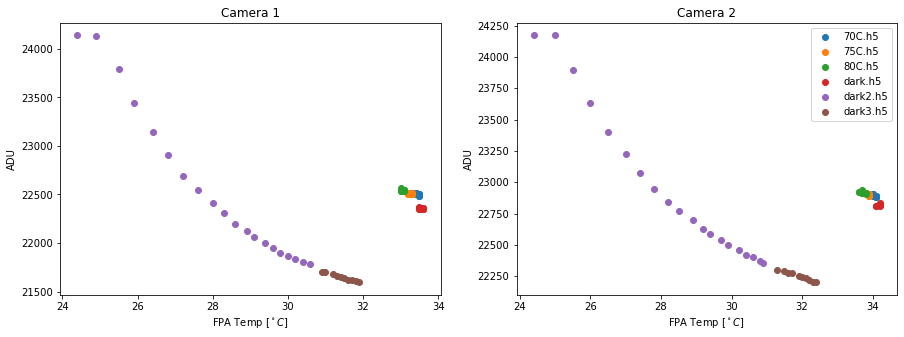

In [131]:
fig, axes = plt.subplots(ncols=2,nrows =1, figsize=(15, 5))
for i in range(len(df_list)):
    axes[0].scatter(df_list[i]['temps1'],get_slice(df_list[i]['imgs1'],150,150))
    axes[1].scatter(df_list[i]['temps2'],get_slice(df_list[i]['imgs2'],150,150),label = df_names[i])
    
axes[1].legend()  
axes[0].set_title('Camera 1')
axes[1].set_title('Camera 2')

# set labels
plt.setp(axes[:], xlabel='FPA Temp [$^\circ C$]')
plt.setp(axes[:], ylabel='ADU')


plt.show()

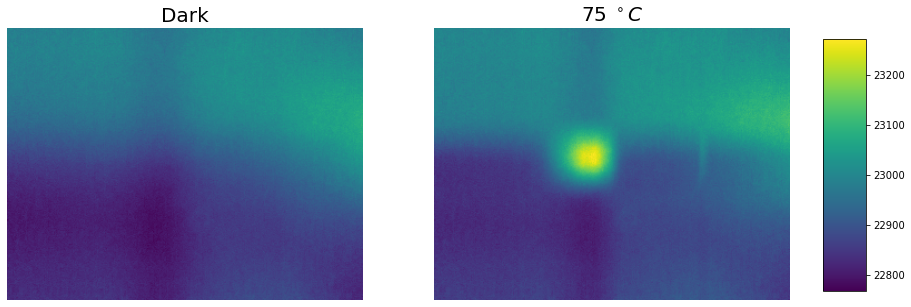

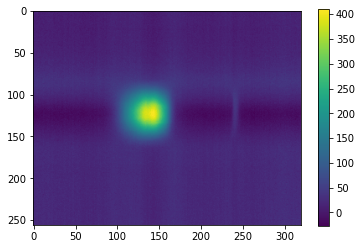

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# generate randomly populated arrays
data1 = df_dark['imgs2'].mean() 
data2 = df_ref['imgs2'].mean()

# find minimum of minima & maximum of maxima
minmin = np.min([np.min(data1), np.min(data2)])
maxmax = np.max([np.max(data1), np.max(data2)])

im1 = axes[0].imshow(data1, vmin=minmin, vmax=maxmax,
                      aspect='auto', cmap='viridis')
im2 = axes[1].imshow(data2, vmin=minmin, vmax=maxmax,
                      aspect='auto', cmap='viridis')

axes[0].axis('off')
axes[0].set_title('Dark',fontsize = 20)
axes[1].axis('off')
axes[1].set_title('75 $^\circ C$',fontsize = 20)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)
plt.show()


plt.imshow(data2-data1)
plt.colorbar()
plt.show()


In [102]:
def f(T, A, B): 
    return A*T + B


In [113]:
def determine_slope(df_ref,ROI1,ROI2):
    '''uses referense measurement to detemine FPA. temp scaling
    df_ref is the reference data imported from the hdf5 file
    ROI are arrays [xmin,xmax,ymin,ymax]
    requires scipy curve_fit and numpy'''
    
   
    A1 = np.zeros([256,320]) #slope
    B1 = np.zeros([256,320]) #offset
    
    for i in range(ROI1[0],ROI1[1]):
        for j in range(ROI1[2],ROI1[3]):
            temps = df_ref['temps1']
            response = get_slice(df_ref['imgs1'],i,j)
            [a,b],cov = curve_fit(f, temps,  response)
            A1[j,i] = a
            B1[j,i] = b
            
    A2 = np.zeros([256,320]) #slope
    B2 = np.zeros([256,320]) #offset
    
    for i in range(ROI2[0],ROI2[1]):
        for j in range(ROI2[2],ROI2[3]):
            temps = df_ref['temps2']
            response = get_slice(df_ref['imgs2'],i,j)
            [a,b],cov = curve_fit(f, temps,  response)
            A2[j,i] = a
            B2[j,i] = b
            
    return(A1,A2)        

In [116]:
[A1,A2] = determine_slope(df_ref,ROI1,ROI2)

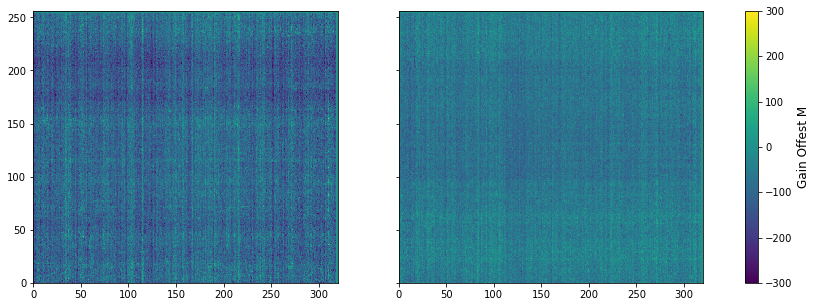

In [120]:
#plot DFCs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(A1,shading = 'auto')
p1.set_clim(-300,300)

p2 = axes[1].pcolormesh(A2,shading = 'auto')
p2.set_clim(-300,300)
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('Gain Offest M',fontsize = 12)

plt.show()

In [105]:
def determine_dark(df_dark,df_ref,A1,A2):
    tref1 =  df_ref['temps1'].value_counts().idxmax() #most common FPA temp
    tref2 =  df_ref['temps2'].value_counts().idxmax() #most common FPA temp
    
    '''determine offset in camera 1 '''
    offsets = [];
    for i in range(len(df_dark)):
        corr = (tref1 - df_dark['temps1'][i])*A1
        offset = (df_dark['imgs1'][i]- corr)
        offsets.append(offset)
    offset1 = np.mean(offsets, axis =0)    
    
    '''determine offset in camera 1 '''
    offsets = [];
    for i in range(len(df_dark)):
        corr = (tref2 - df_dark['temps2'][i])*A1
        offset = (df_dark['imgs2'][i]- corr)
        offsets.append(offset)
    offset2 = np.mean(offsets, axis =0)    
    
    return(tref1,tref2,offset1,offset2)

In [107]:
tref1,tref2,offset1,offset2 = determine_dark(df_dark,df_ref,A1,A2)

In [122]:

'''save coefficients to HDF5'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC" 

#create hdf5 file
hf = h5py.File(save_path + name + '.h5', 'w')

#drift with FPA temps
hf.create_dataset('/M1',     data= A1)
hf.create_dataset('/M2',     data= A2)
hf.create_dataset('/Tref1',  data= tref1)
hf.create_dataset('/Tref2',  data= tref2)
#metadata
hf.create_dataset('/ROI1',  data= ROI1)
hf.create_dataset('/ROI2',  data= ROI2)
hf.close()

In [24]:
def DFC(im,t,tref,offset,A):
    dark_corr = offset + (tref-t)*A
    return(im-dark_corr)
    

In [25]:
def apply_DFC_to_df(df,offset1,offset2,tref1,tref2,A1,A2):
    imgs1 = []; temps1 = []
    imgs2 = []; temps2 = []
    for i in range(len(df)):
        im1  = df['imgs1'][i]
        t1   = df['temps1'][i]
        im1c =DFC(im1,t1,tref1,offset1,A1)# take offset
        im1c = im1c + (tref1-t1)*A1 #rescale gain
        
        im2  = df['imgs2'][i]
        t2   = df['temps2'][i]
        im2c =DFC(im2,t2,tref2,offset2,A2) 
        im2c = im2c + (tref2-t2)*A2 #rescale gain

        imgs1.append(im1c);temps1.append(t1)
        imgs2.append(im2c);temps2.append(t2)
        
    data_corrected = {'imgs1': imgs1,'imgs2': imgs2,'temps1': temps1, 'temps2' : temps2}
    df_corrected = pd.DataFrame.from_dict(data_corrected)
    return(df_corrected)

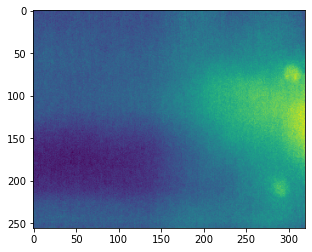

In [52]:
plt.imshow(offset1)

In [59]:
df80 = apply_DFC_to_df(df_list[45],offset1,offset2,tref1,tref2,0,0);
df75 = apply_DFC_to_df(df_list[35],offset1,offset2,tref1,tref2,0,0);
df70 = apply_DFC_to_df(df_list[25],offset1,offset2,tref1,tref2,0,0);

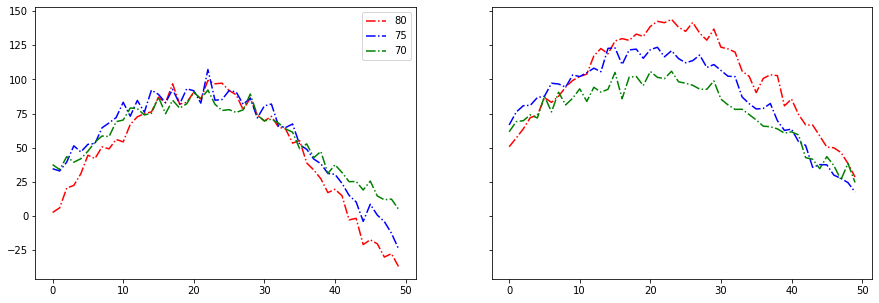

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

axes[0].plot(df80['imgs1'][5][ROI1[2]:ROI1[3],ROI1[0] + 25],'-.r',label = '80')
axes[0].plot(df75['imgs1'][5][ROI1[2]:ROI1[3],ROI1[0] + 25],'-.b',label = '75')
axes[0].plot(df70['imgs1'][5][ROI1[2]:ROI1[3],ROI1[0] + 25],'-.g',label = '70')
axes[0].legend()

axes[1].plot(df80['imgs2'][5][ROI2[2]:ROI2[3],ROI2[0] + 25],'-.r')
axes[1].plot(df75['imgs2'][5][ROI2[2]:ROI2[3],ROI2[0] + 25],'-.b')
axes[1].plot(df70['imgs2'][5][ROI2[2]:ROI2[3],ROI2[0] + 25],'-.g')

plt.show()

In [31]:
'''apply pixel registration'''
#choose filepath to desired data
path = '/Volumes/KESU/mar26/polarized/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

waves= np.linspace(7,12,61)

In [47]:

def correct_df(df,cal_file1,cal_file2,ROI1,ROI2):
    corrected_images1= [] ;
    corrected_images2= [] ; 

    for i in range(len(df)):
        #first without NUC correction
        r = df['imgs1'][i];
        cn = pixel_registration(r,cal_file1,waves,ROI1[2],ROI1[3])
        corrected_images1.append(cn)

        #first without NUC correction
        r = df['imgs2'][i];
        cn = pixel_registration(r,cal_file2,waves,ROI2[2],ROI2[3])
        corrected_images2.append(cn)

    im1 = np.mean(corrected_images1,axis =0)    
    im2 = np.mean(corrected_images2,axis =0)    
    return(im1,im2)

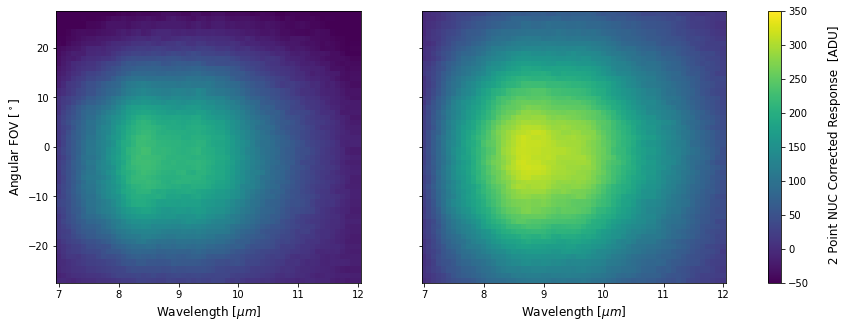

In [71]:
im1,im2 = correct_df(df80,cal_file1,cal_file2,ROI1,ROI2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
X,Y = np.meshgrid(waves,angles)

p1 = axes[0].pcolormesh(X,Y,im1,shading = 'auto')
p1.set_clim([-50,350])
axes[0].set_ylabel('Angular FOV [$^\circ$]',fontsize = 12)
axes[0].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)
#axes[0].title('Camera 1')

p2 = axes[1].pcolormesh(X,Y,im2,shading = 'auto')
p2.set_clim([-50,350])
axes[1].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)
#axes[1].title('Camera 2')
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n 2 Point NUC Corrected Response  [ADU]',fontsize = 12)

plt.show()


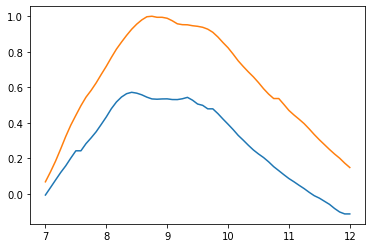

In [68]:
maxmax = np.max([np.max(np.mean(im1,axis = 0)),np.max(np.mean(im2,axis = 0))])
transmission1 = np.mean(im1,axis = 0)/maxmax
transmission2 = np.mean(im2,axis = 0)/maxmax

plt.plot(waves,transmission1)
plt.plot(waves,transmission2)
plt.show()

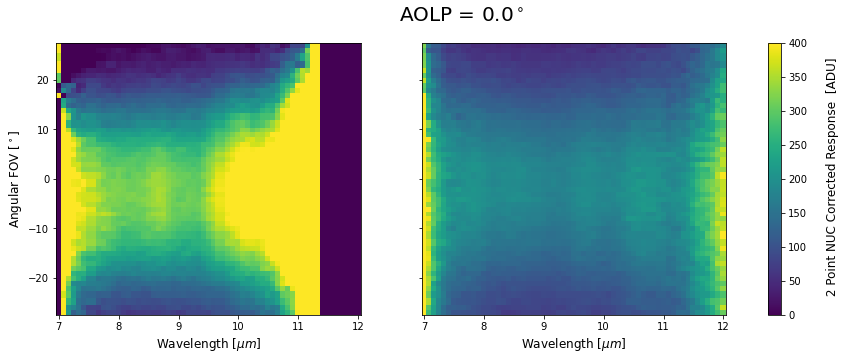

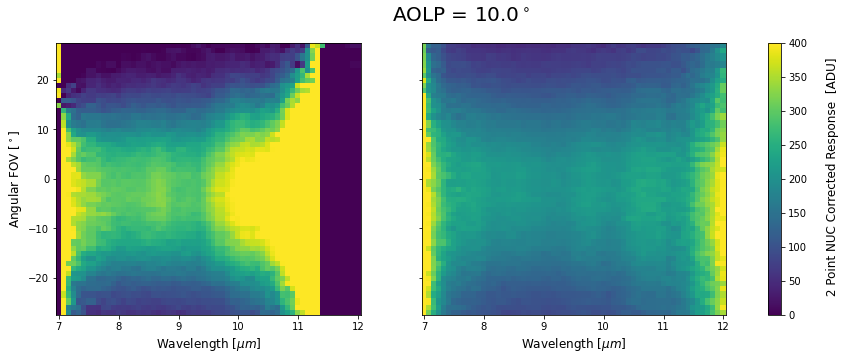

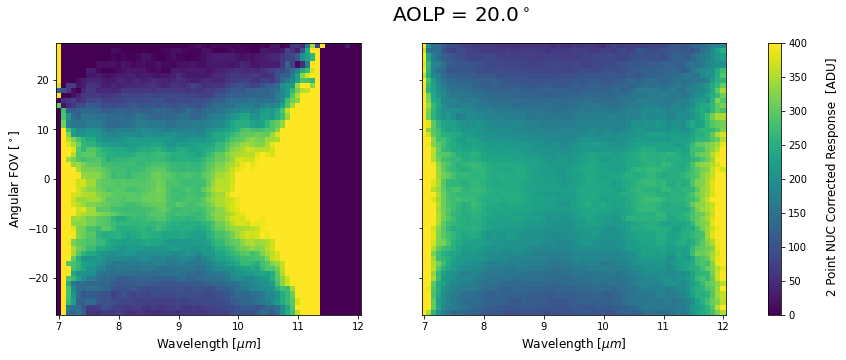

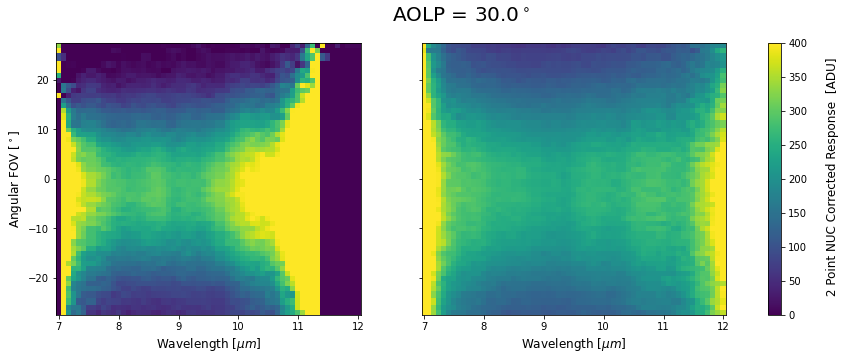

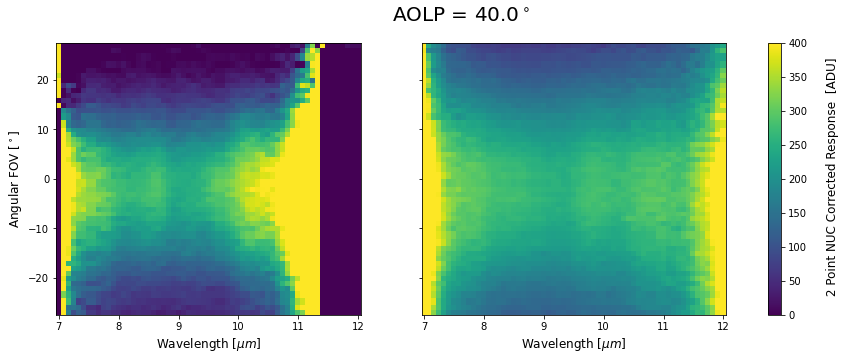

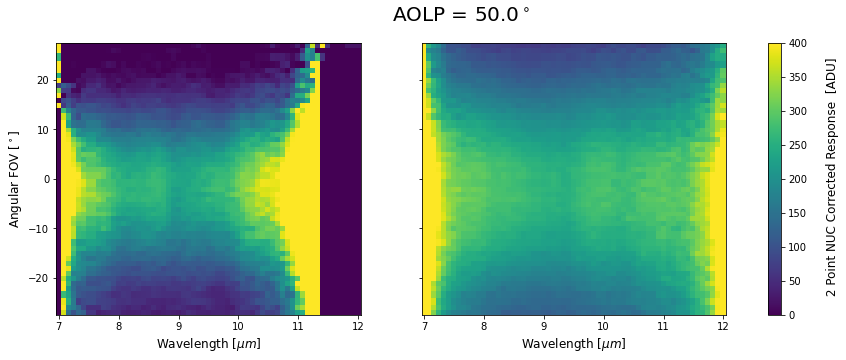

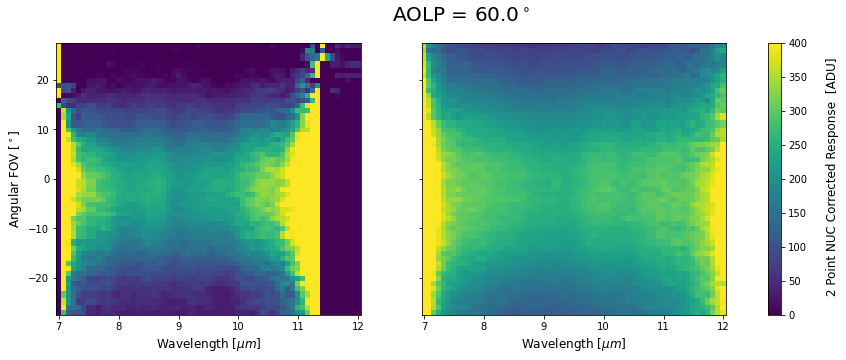

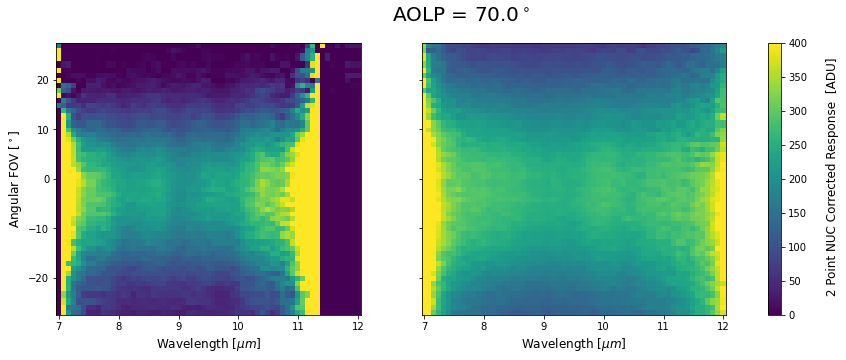

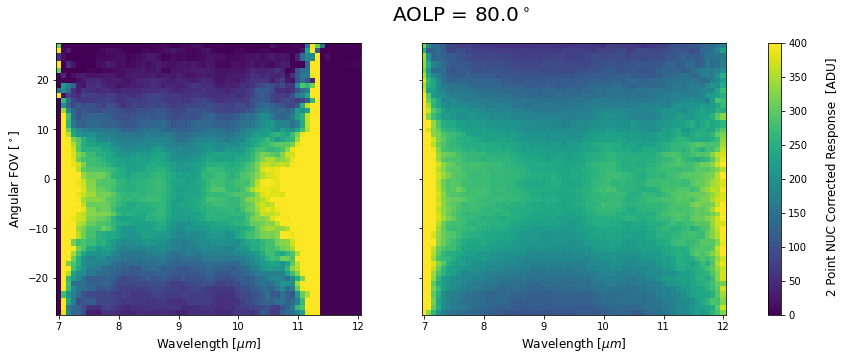

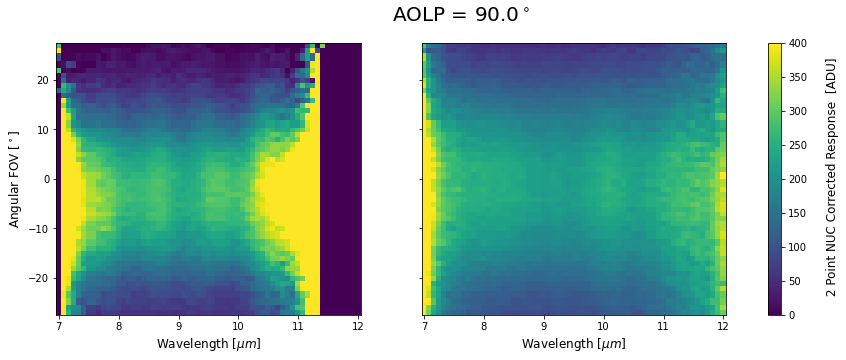

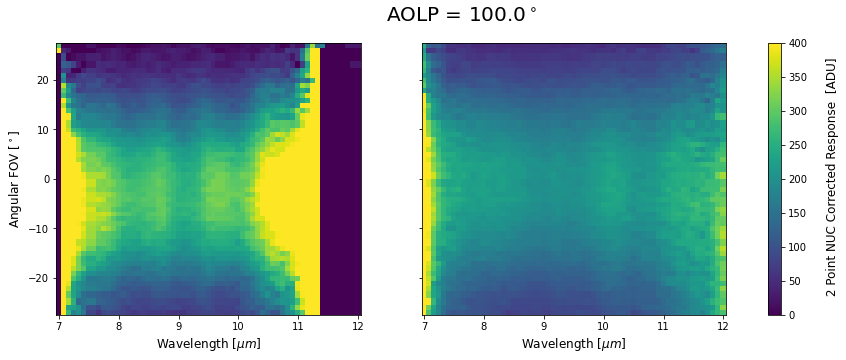

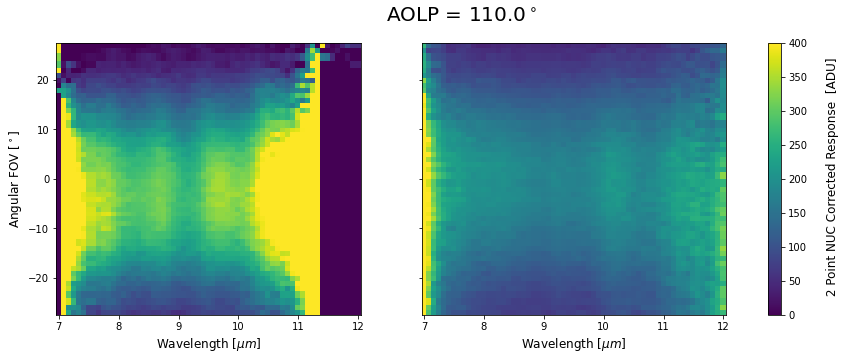

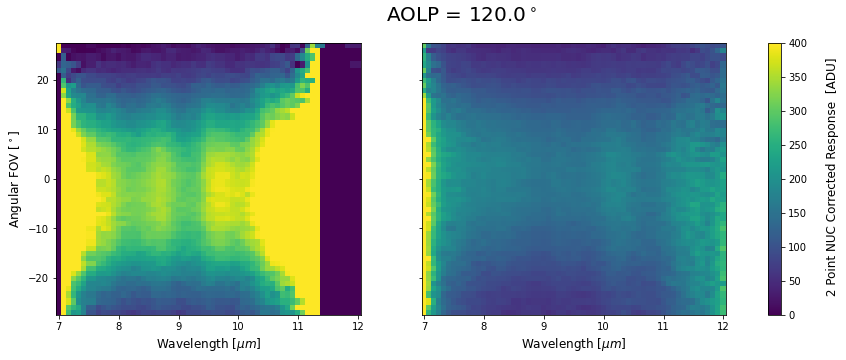

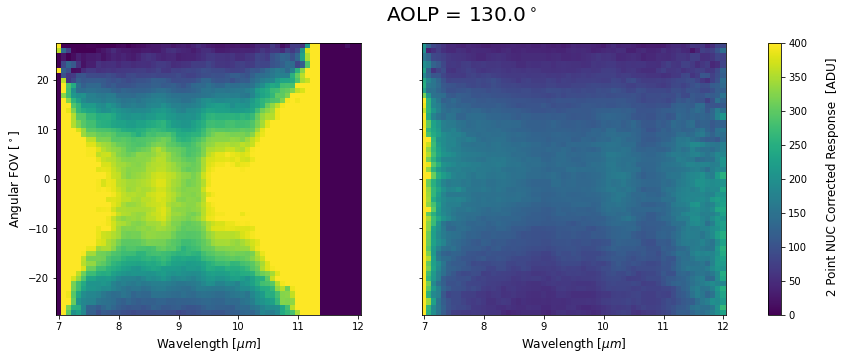

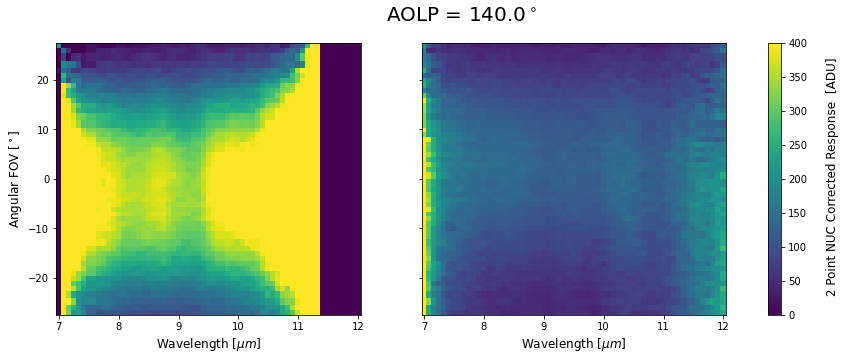

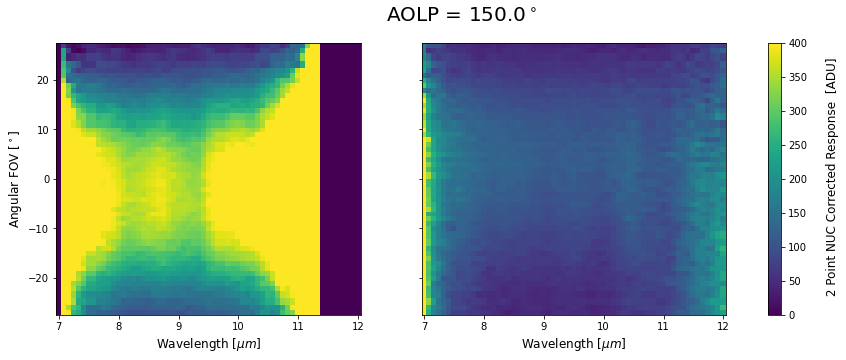

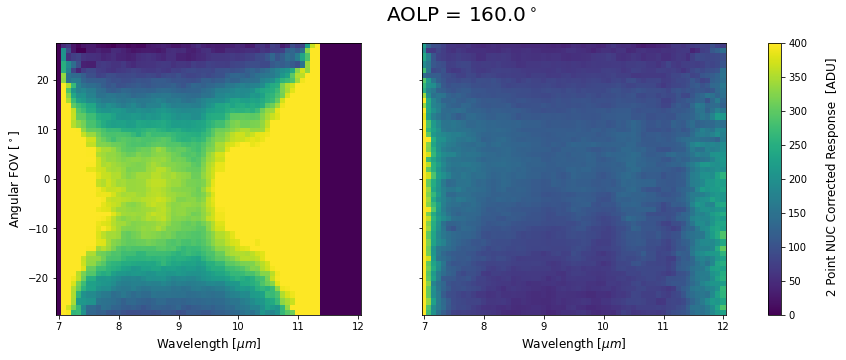

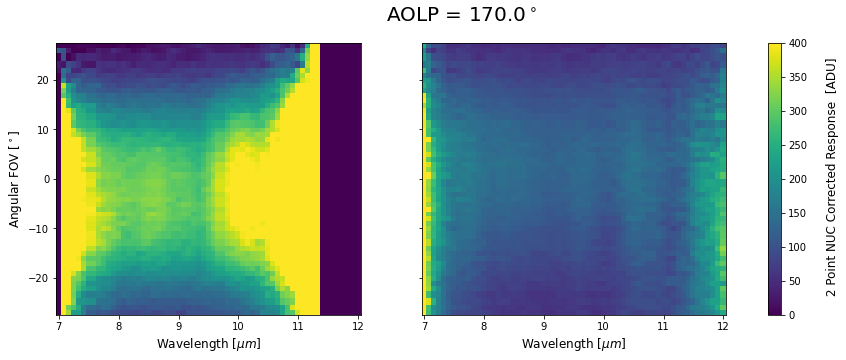

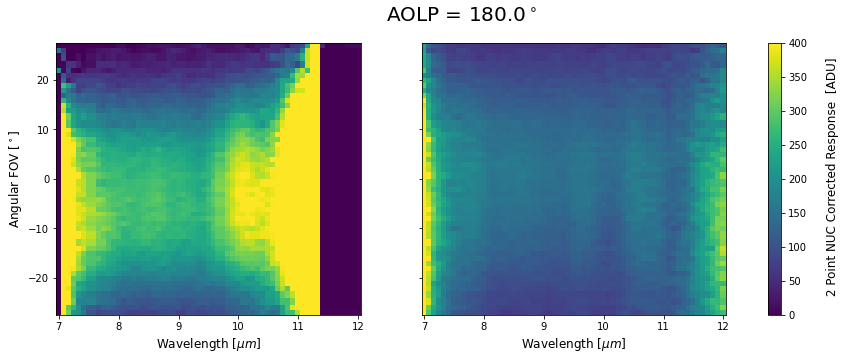

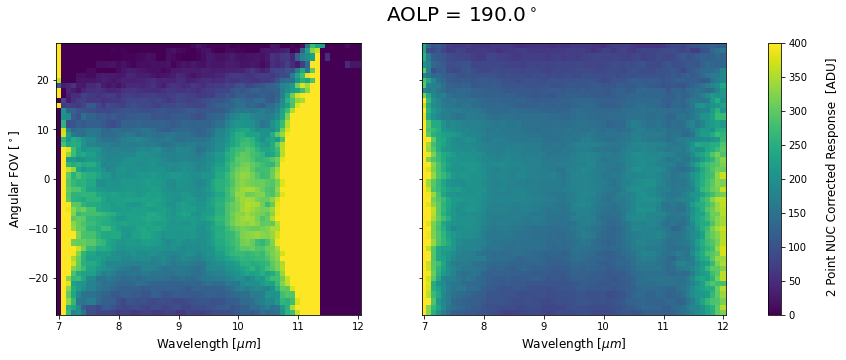

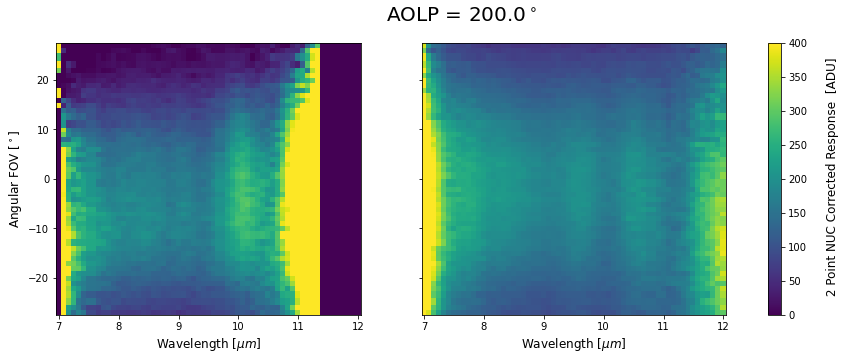

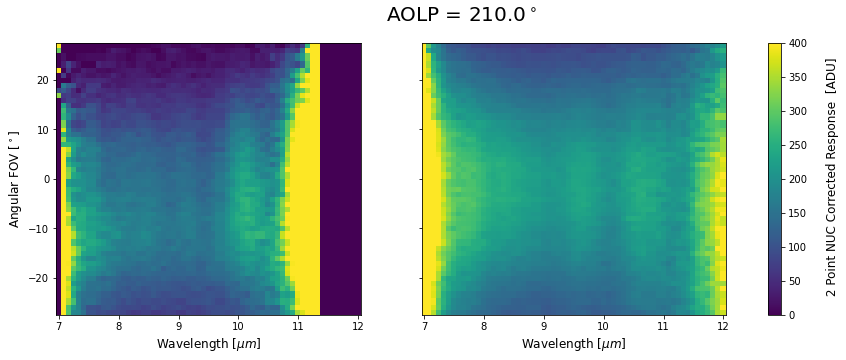

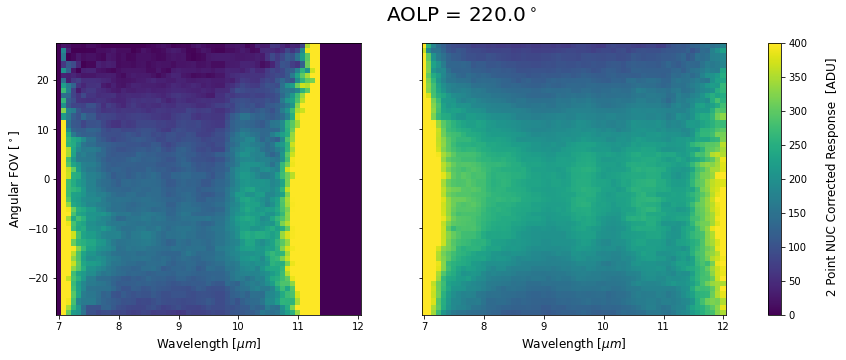

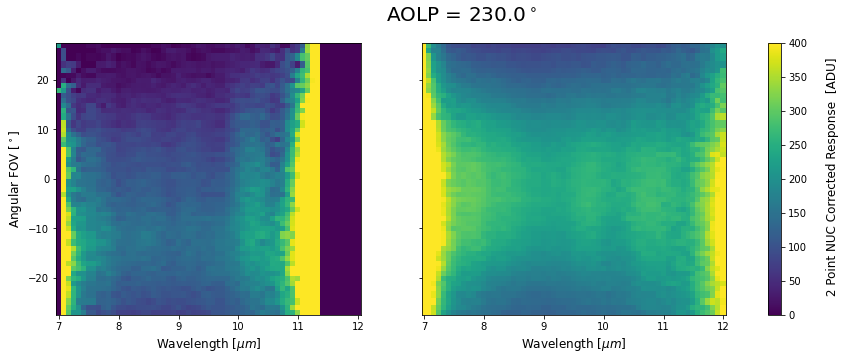

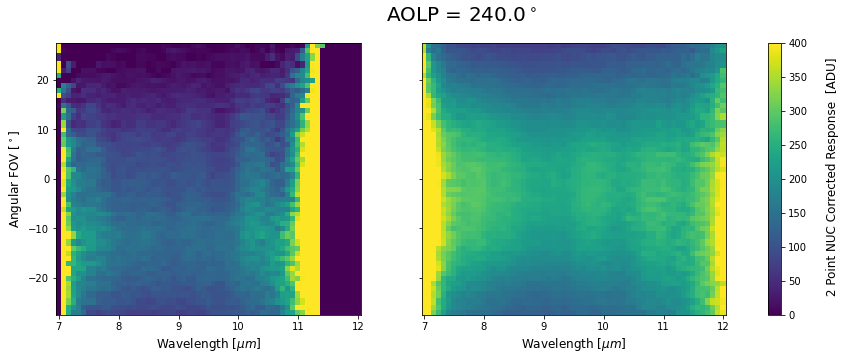

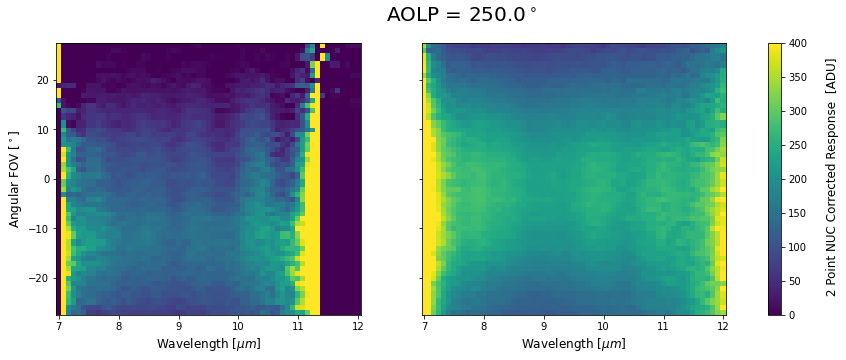

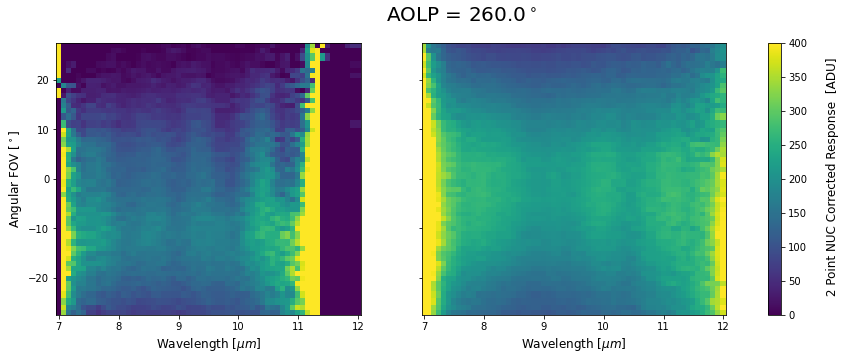

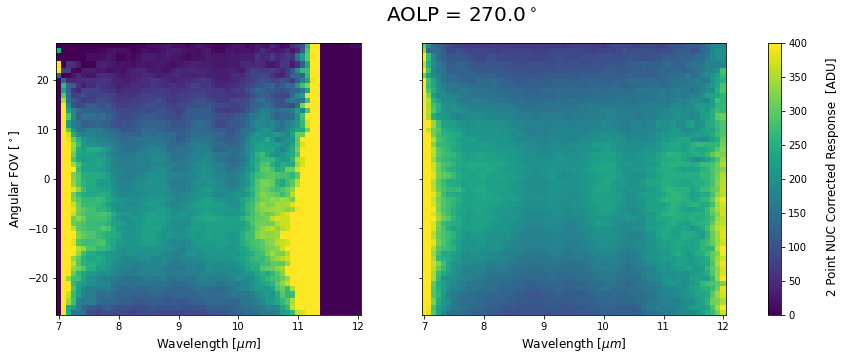

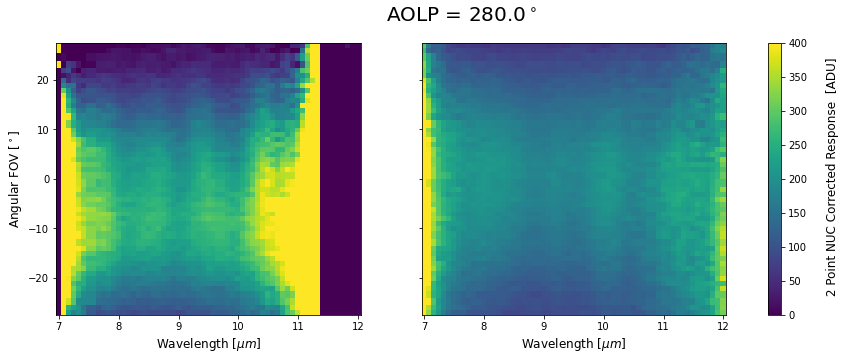

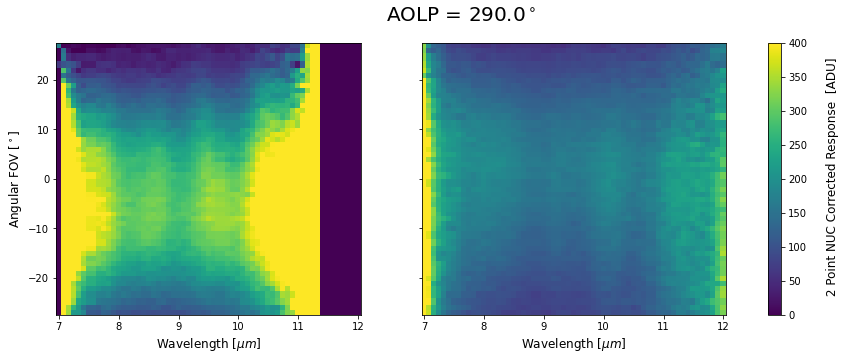

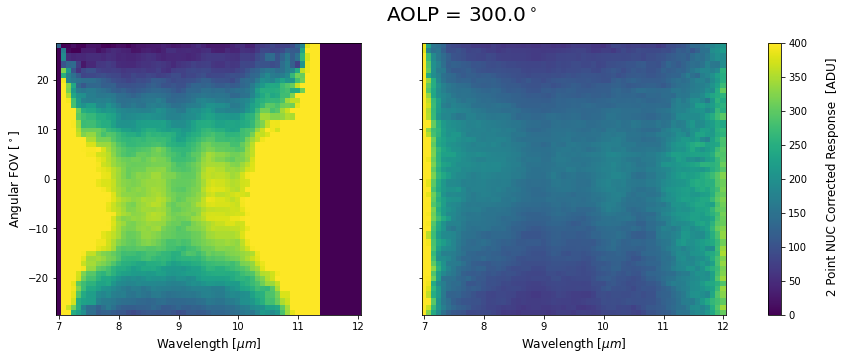

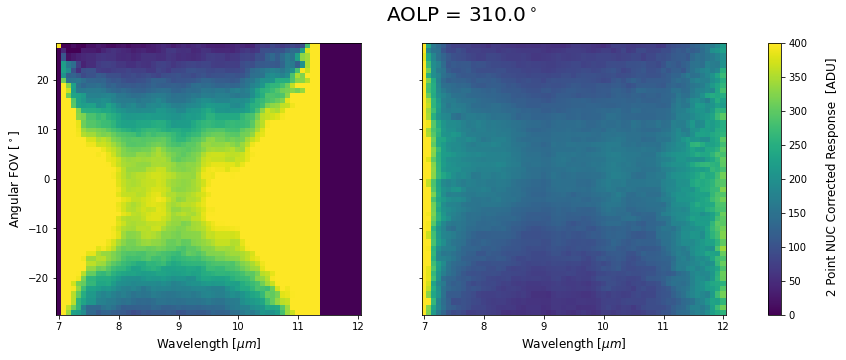

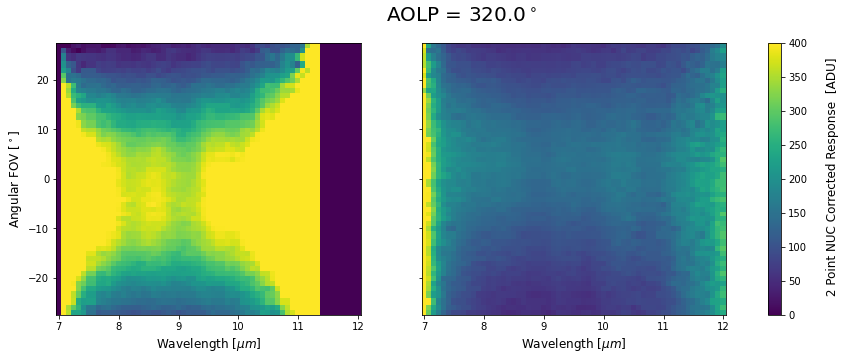

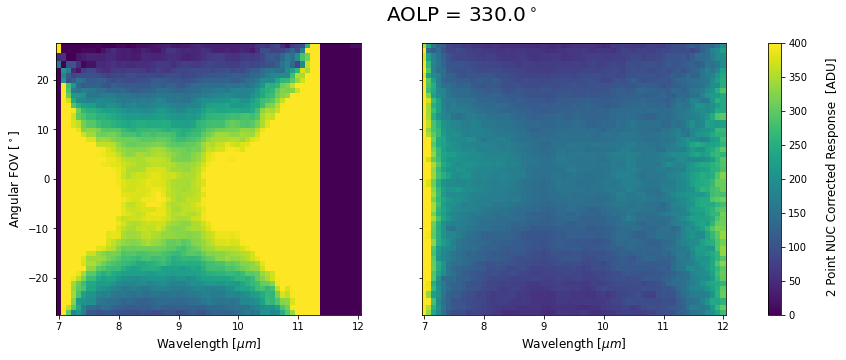

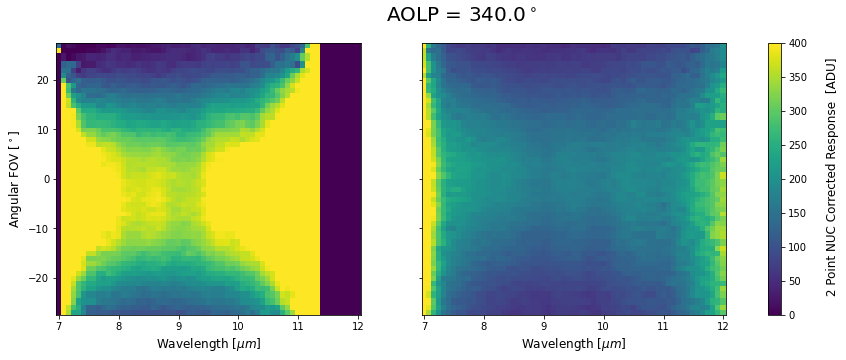

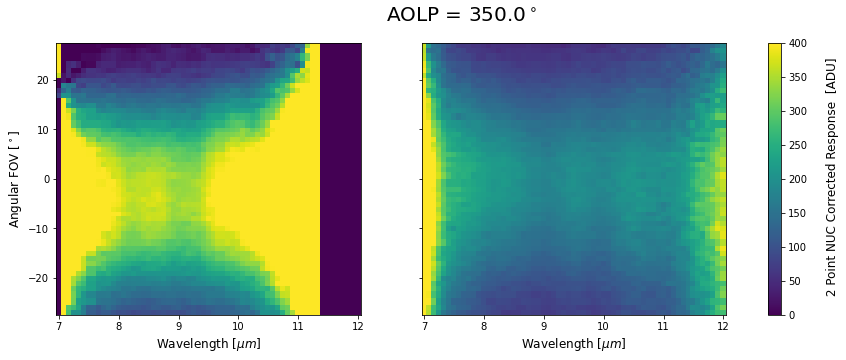

In [73]:
path = '/Volumes/KESU/apr06/polarized/'
spath = '/Volumes/KESU/apr06/polarized/images2/'
lps = np.round(np.linspace(0,350,36),1)

j = 0;
for l in lps:
    fn = str(int(l))+'deg.h5'
    df = create_LUT_df(path,fn)
    dfc = apply_DFC_to_df(df,offset1,offset2,tref1,tref2,A1,A2)
    
    im1,im2 = correct_df(dfc,cal_file1,cal_file2,ROI1,ROI2)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
    X,Y = np.meshgrid(waves,angles)

    p1 = axes[0].pcolormesh(X,Y,im1/transmission1,shading = 'auto')
    p1.set_clim([0,400])
    axes[0].set_ylabel('Angular FOV [$^\circ$]',fontsize = 12)
    axes[0].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)

    p2 = axes[1].pcolormesh(X,Y,im2/transmission2,shading = 'auto')
    p2.set_clim([0,400])
    axes[1].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)

    cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
    cbar.ax.set_ylabel('\n 2 Point NUC Corrected Response  [ADU]',fontsize = 12)
    
    plt.suptitle('AOLP = '+ str(l) + '$^\circ$',fontsize = 20)
    plt.show()
    
    #fig.savefig(spath +'plot'+str(j)+'.png')
    j = j+1



In [325]:
'''animate'''
import imageio
from pathlib import Path

image_path = Path(spath)
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite(spath +'images.gif', image_list,fps = 1)    

In [386]:
'''make polarized df'''
path = '/Volumes/KESU/mar26/polarized/'
i1 = []
i2 = []
for l in lps:
    fn = str(int(l))+'deg.h5'
    df = create_LUT_df(path,fn)
    dfc = apply_DFC_to_df(df,offset1,offset2,tref1,tref2,A1,A2)
    
    im1,im2 = correct_df(dfc,cal_file1,cal_file2,ROI1,ROI2)
    
    im1 = im1/transmission1
    im2 = im2/transmission2
    
    im1 = np.mean(im1[20:30],axis =0)
    im2 = np.mean(im2[20:30],axis =0)
    
    i1.append(im1)
    i2.append(im2)

Text(0, 0.5, '\n 2 Point NUC Corrected Response  [ADU]')

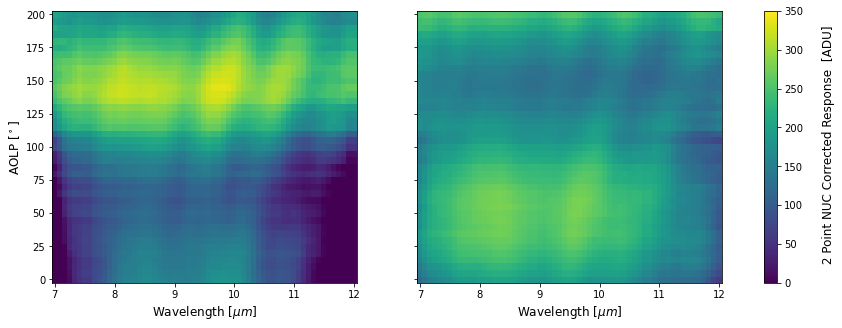

In [387]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
X,Y = np.meshgrid(waves,lps)

p1 = axes[0].pcolormesh(X,Y,i1,shading = 'auto')
p1.set_clim([0,350])
axes[0].set_ylabel('AOLP [$^\circ$]',fontsize = 12)
axes[0].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)

p2 = axes[1].pcolormesh(X,Y,i2,shading = 'auto')
p2.set_clim([0,350])
axes[1].set_xlabel('Wavelength [$\mu m$]'  ,fontsize = 12)

cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n 2 Point NUC Corrected Response  [ADU]',fontsize = 12)


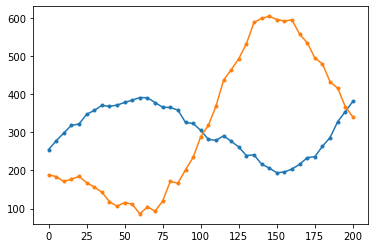

In [427]:
k = 45
plt.plot(lps,np.transpose(i2/transmission2)[k],'.-')
plt.plot(lps,np.transpose(i1/transmission1)[k],'.-')

In [415]:
def funct(x,a,b,c,d):
    return(a*np.cos(d*x+c)+b)

In [418]:
response = np.transpose(i2/transmission2)[45]
[a,b,c,d],cov = curve_fit(funct, response,lps)

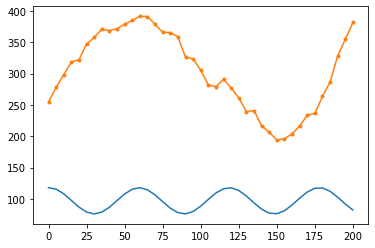

In [419]:
plt.plot(lps,funct(lps,a,b,c,d))
plt.plot(lps,response,'.-')